# Apprendimento per rinforzo

Per illustrare un altro esempio di stima dei parametri mediante massima verosimiglianza, prendiamo in considerazione uno dei modelli psicologici di maggior successo: il modello di apprendimento di Rescorla-Wagner.

Il presente tutorial trae ispirazione dall'articolo di [Wilson & Collins (2019)](https://elifesciences.org/articles/49547) e utilizza il codice fornito da [Rhoads, S. A. & Gan, L. (2022)](https://shawnrhoads.github.io/gu-psyc-347/index.html).

In [1]:
from scipy.optimize import minimize  # finding optimal params in models
from scipy import stats             # statistical tools
import numpy as np                  # matrix/array functions
import pandas as pd                 # loading and manipulating data
import ipywidgets as widgets        # interactive display
import matplotlib.pyplot as plt     # plotting
%matplotlib inline

np.random.seed(2023)                # set seed for reproducibility

Lo scopo degli studi sull'apprendimento per rinforzo è quello di comprendere come le persone imparano a massimizzare le loro ricompense in situazioni in cui la scelta migliore è inizialmente sconosciuta. In modo più specifico, consideriamo il seguente problema di apprendimento. Un partecipante deve effettuare ripetutamente delle scelte tra diverse opzioni o azioni, e dopo ogni scelta riceve una ricompensa numerica estratta da una distribuzione di probabilità che dipende dall'azione selezionata. L'obiettivo del partecipante è massimizzare la ricompensa totale attesa durante un certo periodo di tempo, ad esempio, durante 100 scelte. Per descrivere questa situazione, viene spesso utilizzata la metafora di un giocatore che deve fare una serie di $T$ scelte tra $K$ slot machine (conosciute anche come "multi-armed bandits") al fine di massimizzare le sue vincite. Se nella scelta $t$ viene selezionata la slot machine $k$, viene ottenuta una ricompensa $r_t$ che ha valore `1` con una probabilità di successo $\mu^k_t$, altrimenti ha valore `0`. Le probabilità di successo sono diverse per ogni slot machine e inizialmente sono sconosciute al partecipante. Nella versione più semplice di questo compito, le probabilità di successo rimangono costanti nel tempo.

In questo problema, ogni azione ha un valore associato, che rappresenta la ricompensa attesa quando quella specifica azione viene selezionata. Chiamiamo questo valore "valore dell'azione". Se si conosce il valore di ogni azione, risolvere il problema di apprendimento significa semplicemente selezionare l'azione con il valore più alto.

Abbiamo tre parametri per questo problema:
1. il numero di tentativi, $T$
2. il numero di slot machine, $K$
3. le probabilità di ricompensa delle diverse opzioni, $\mu^k_t$, che possono o meno variare nel tempo.

In questo tutorial simuleremo il comportamento di due slot machine basato sul modello di apprendimento Rescorla-Wagner. Imposteremo `T = 100` (100 tentativi), `K = 2` (due slot machine) e `mu = [.2, .8]` (la slot machine 1 fornisce una ricompensa con probabilità del 20%, la slot machine 2 fornisce una ricompensa con probabilità dell'80%).

In [2]:
T = 100
K = 2
mu = [0.2, 0.8]


Rescorla e Wagner (1972) hanno proposto, in uno dei grandi articoli del XX secolo, che l'apprendimento avvenga attraverso l'errore di previsione. Nel loro modello, i partecipanti imparano inizialmente il valore atteso di ogni slot machine basandosi sulla storia dei risultati precedenti e utilizzano tali valori per prendere decisioni future. Nel modello di apprendimento di Rescorla-Wagner, il valore dell'opzione $k$, indicato come $Q^k_t$, viene aggiornato in risposta alla ricompensa $r_t$ utilizzando la seguente equazione:

$$
Q^k_{t+1} = Q^k_t + \alpha (r_t - Q^k_t),
$$

dove $\alpha$ è il tasso di apprendimento, che è compreso tra 0 e 1 e rappresenta l'entità con cui l'errore di previsione, $(r_t - Q^k_t)$, aggiorna il valore (ovvero, l'aspettativa di ricompensa) di una slot machine (ad esempio, un valore $\alpha$ più elevato attribuisce maggior peso all'errore di previsione). Per semplicità, assumiamo il valore iniziale $Q^k_0=0$, anche se è possibile trattare $Q^k_0$ come un parametro libero del modello.

Un semplice modello del processo decisionale consiste nell'ipotizzare che i partecipanti utilizzino i valori (aspettative di ricompensa) delle opzioni (cioè, delle slot machine) per guidare le loro decisioni, scegliendo più frequentemente l'opzione con l'aspettativa maggiore di ricompensa, ma occasionalmente commettendo degli 'errori' (ovvero, esplorando l'alternativa) scegliendo un'opzione con un valore più basso. Una regola di scelta con queste proprietà è nota come regola di scelta **'softmax'**, che sceglie l'opzione $k$ con una probabilità data da:

$$
p^k_t = \frac{\exp(\theta Q^k_t)}{\sum_{i=1}^K \exp(\theta Q^i_t)},
$$

dove il parametro $\theta$, detto 'temperatura', controlla il livello di casualità nella scelta, variando da $\theta = 0$ per risposte completamente casuali a $\theta = \infty$ per la scelta deterministica dell'opzione con il valore più alto. In altre parole, una persona con un valore alto di $\theta$ sceglierà quasi sempre l'opzione con il valore più alto ($Q^k_t$), mentre una persona con un valore basso di $\theta$  esplorerà più frequentemente le altre opzioni. 

Per fare un esempio, definiamo la funzione softmax (o funzione esponenziale normalizzata)

In [ ]:
def softmax(Q, theta):
    p = np.exp(theta * Q) / np.sum(np.exp(theta * Q))
    return p

e consideriamo alcuni valori di `Q` e `theta`

In [63]:
Q = np.array([0.25, 0.65])
theta = 3.5
softmax(Q, theta)

array([0.19781611, 0.80218389])

In [62]:
Q = np.array([0.10, 0.75])
theta = 0.5
softmax(Q, theta)


array([0.4194577, 0.5805423])

Si noti come la funzione softmax consente di convertire i valori `Q` e `theta` in una distribuzione di probabilità. 

Teniamo ora fissi i valori di `Q` e facciamo variare `theta`.

In [ ]:
Q = np.array([0.1, 0.75])
theta_values = np.linspace(0, 5, 100)

Calcoliamo la probabilità.

In [ ]:
probabilities_list = []
for theta in theta_values:
    probabilities = softmax(Q, theta)
    probabilities_list.append(probabilities)

In [ ]:
probabilities_array = np.array(probabilities_list).T
option_labels = ['Option 1', 'Option 2']


Nel codice fornito, `probabilities_list` è una lista di array che contiene le probabilità di scegliere ciascuna opzione per diversi valori di `theta`. Ogni array in `probabilities_list` rappresenta le probabilità per una specifica opzione. Per manipolare e accedere ai dati in modo più conveniente, convertiamo `probabilities_list` in un array NumPy utilizzando `np.array(probabilities_list)`.

`.T` alla fine trasponi l'array, scambiando le righe con le colonne. Questa operazione è necessaria perché `probabilities_list` è strutturato in modo tale che ogni riga corrisponda a una specifica opzione, e desideriamo che ogni colonna rappresenti le probabilità per un valore specifico di `theta`.

Dopo aver trasposto l'array, lo assegniamo a `probabilities_array`. Ora, ogni colonna di `probabilities_array` corrisponde a un valore specifico di `theta`, e ogni riga rappresenta le probabilità di scegliere una particolare opzione per quel valore di `theta`.

Inoltre, `option_labels` è una lista che contiene le etichette per le opzioni. In questo caso, contiene le etichette `'Opzione 1'` e `'Opzione 2'`. Queste etichette vengono utilizzate per creare la legenda nel grafico, fornendo una rappresentazione visuale di quale linea corrisponda a quale opzione.

Possiamo ora disegnare le varie distribuzioni di probabilità ottenute da softmax in funzione dei valori `theta`.

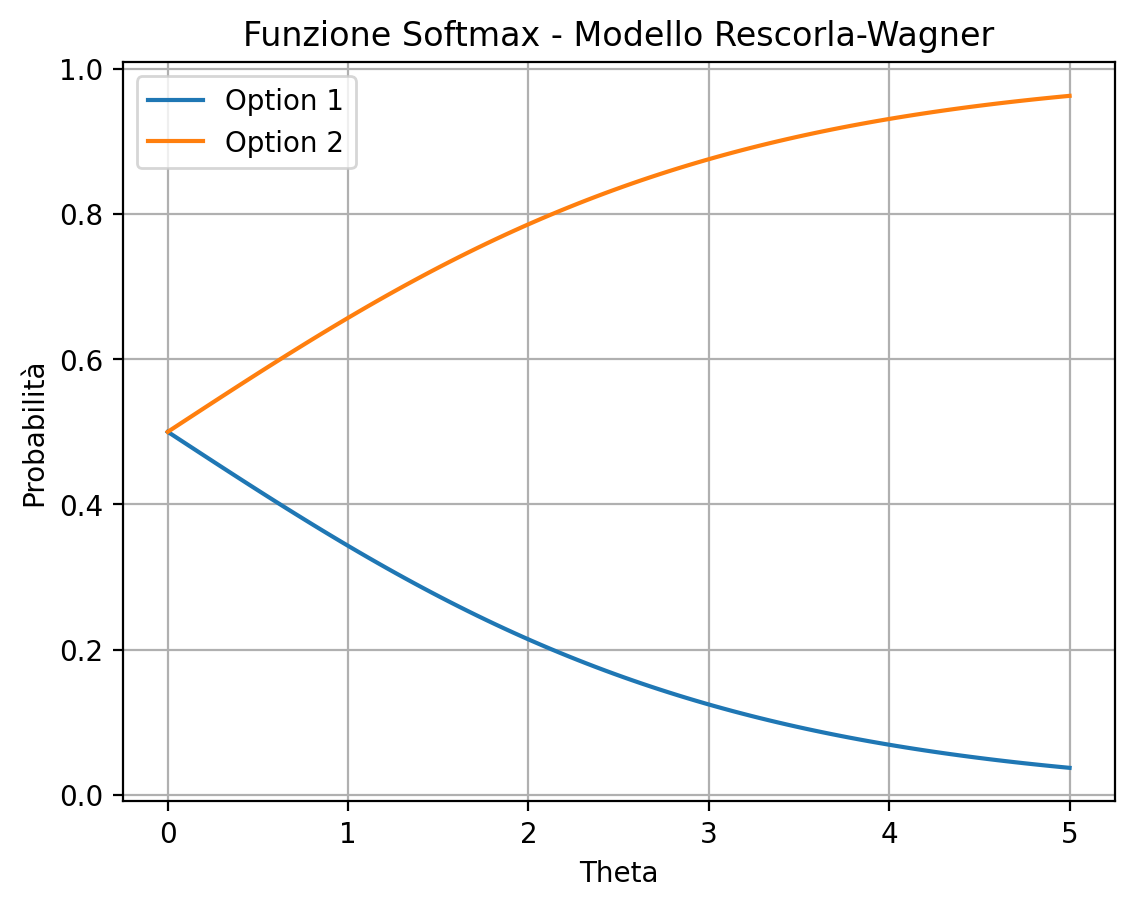

In [67]:
plt.figure()
for i in range(len(option_labels)):
    plt.plot(theta_values, probabilities_array[i], label=option_labels[i])

plt.xlabel('Theta')
plt.ylabel('Probabilità')
plt.title('Funzione Softmax - Modello Rescorla-Wagner')
plt.legend()
plt.grid(True)
plt.show()


Il grafico risultante mostra come le probabilità di scelta cambiano al variare del parametro `theta`, consentendoci di visualizzare l'effetto del parametro `theta` sulla distribuzione di probabilità nel modello Rescorla-Wagner. Quando $\theta$ è vicino a zero, la funzione softmax produce una distribuzione di probabilità uniforme, rendendo la scelta completamente casuale. Quando $\theta$ tende all'infinito, la funzione softmax privilegia sempre l'opzione con il valore stimato più alto, rendendo la scelta deterministica. In altre parole, un valore maggiore di $\theta$ fa sì che l'opzione con il valore stimato più alto abbia una probabilità di scelta più alta, mentre valori più bassi di $\theta$ permettono una maggiore esplorazione delle opzioni con valori stimati più bassi.

Combinando la regola di apprendimento e la regola decisionale, otteniamo un modello del processo decisionale  con due parametri liberi: il tasso di apprendimento $\alpha$ e la temperatura inversa $\theta$.

In [3]:
def simulate_RescorlaWagner(params, T, mu, noisy_choice=True):

    alpha, theta = params
    
    # Un array di zeri di lunghezza T
    c = np.zeros((T), dtype=int)
    r = np.zeros((T), dtype=int)

    # Un array multidimensionale di zeri di dimensione 2xT
    Q_stored = np.zeros((2, T), dtype=float)
    
    # Inizializza Q per t == 0
    Q = [0.5, 0.5]

    for t in range(T):

        # Salva i valori Q per Q_{t+1}
        Q_stored[:, t] = Q

        # Calcola le probabilità di scelta
        p0 = np.exp(theta*Q[0]) / (np.exp(theta*Q[0]) + np.exp(theta*Q[1]))
        p1 = 1 - p0
        
        # Se noisy_choice è vero, viene simulato un comportamento di scelta rumoroso in 
        # cui l'opzione 0 è scelta con probabilità p0, mentre l'opzione 1 è scelta con 
        # probabilità 1-p0.
        if noisy_choice:
            if np.random.random_sample(1) < p0:
                c[t] = 0
            else:
                c[t] = 1
        else:  # la scelta viene effettuata senza rumore
            c[t] = np.argmax([p0, p1])

        # Genera la ricompensa sulla base delle probabilità di ricompensa
        r[t] = np.random.rand() < mu[c[t]]

        # Aggiorna le aspettative di valore
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta

    return c, r, Q_stored


Simuliamo `T` = 100 prove utilizzando il modello generativo dei dati definito in precedenza.

In [68]:
c3, r3, Q = simulate_RescorlaWagner([.1, 2.5], T=T, mu=mu)


Rappresentiamo graficamente i risultati ottenuti dalla simulazione.

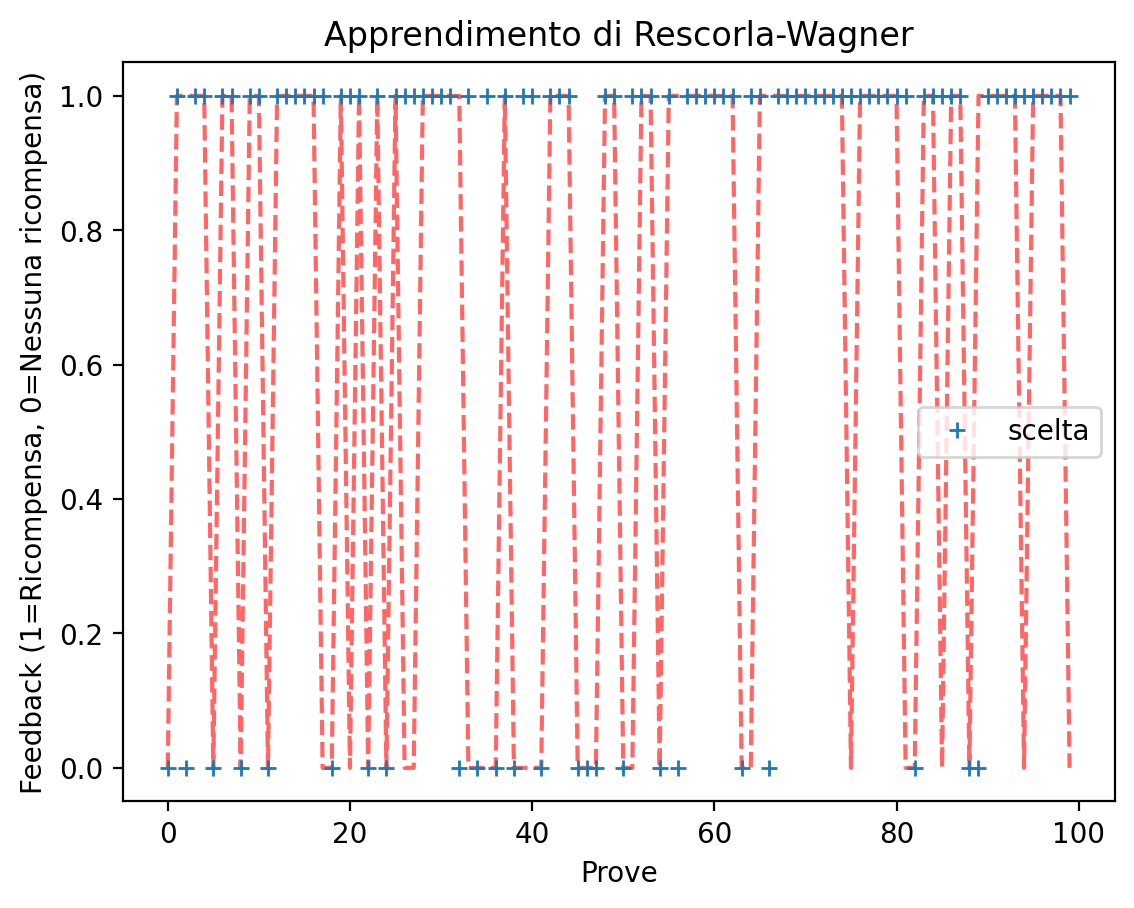

In [73]:
plt.plot(range(T), r3, 'r--', alpha=.6)
plt.plot(range(T), c3, '+', label='scelta')
plt.xlabel('Prove')
plt.ylabel('Feedback (1=Ricompensa, 0=Nessuna ricompensa)')
plt.title(f'Apprendimento di Rescorla-Wagner')
plt.legend()
plt.show()


Come possiamo osservare, le scelte per la slot machine che produce meno ricompense diventano meno frequenti nel corso delle prove.

Possiamo anche rappresentare graficamente le aspettative di valore $Q$ delle due slot machine nel corso delle prove. 

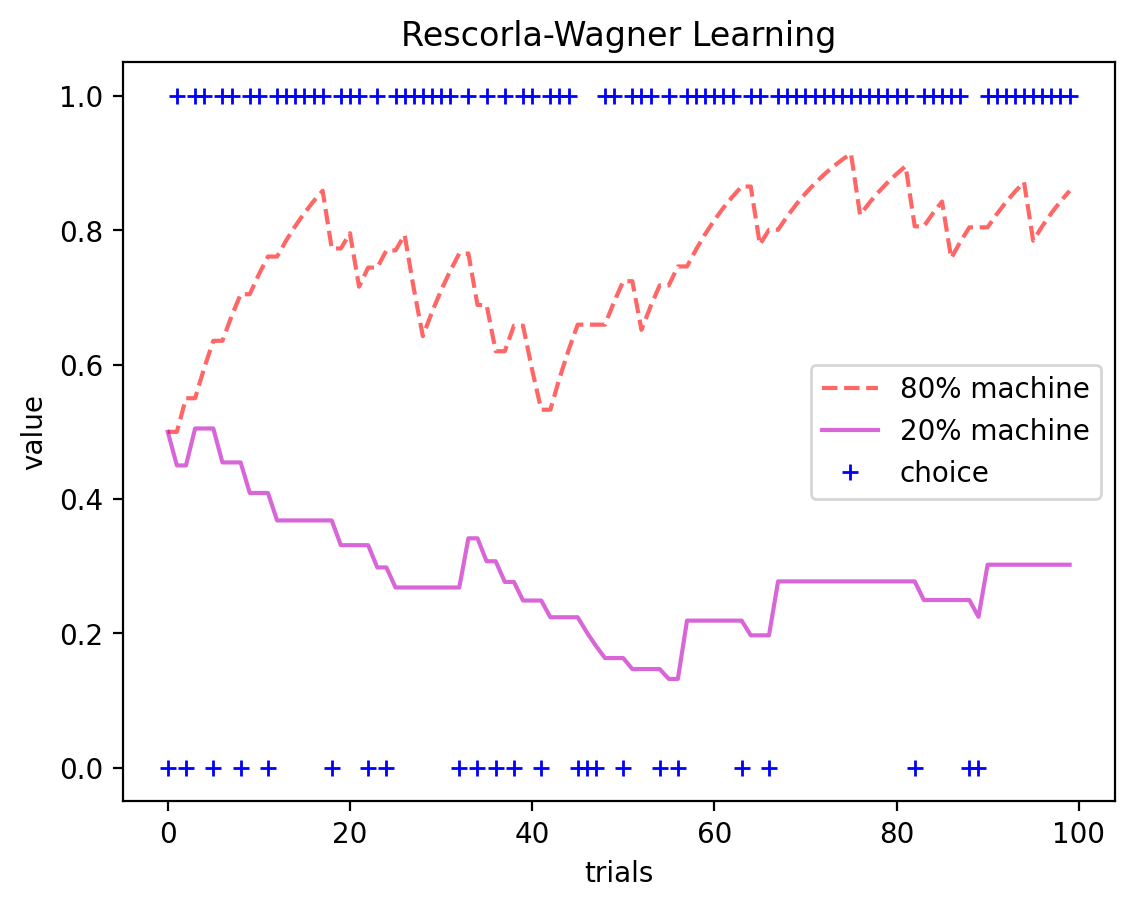

In [74]:
plt.plot(range(T), Q[1, :], 'r--', alpha=.6, label='80% machine')
plt.plot(range(T), Q[0, :], 'm-', alpha=.6, label='20% machine')
plt.plot(range(T), c3, 'b+', label='choice')
plt.xlabel('trials')
plt.ylabel('value')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()


Si noti come nel corso delle prove i valori delle slot macchine convergano lentamente verso le probabilità di ricompensa (20% e 80%).

Il seguente codice genera un widget interattivo all'interno di un Jupyter Notebook, che consente di manipolare i parametri del modello Rescorla-Wagner in tempo reale.

In [9]:
def plot_values(beta_hat, theta_hat, T, mu):
    c, r, Q = simulate_RescorlaWagner([beta_hat, theta_hat], T, mu)

    plt.plot(range(T), Q[1, :], 'r--', alpha=.6,
             label=f'{mu[1]*100:.0f}% machine')
    plt.plot(range(T), Q[0, :], 'm-', alpha=.6,
             label=f'{mu[0]*100:.0f}% machine')
    plt.plot(range(T), c, 'b+', label='choice')
    plt.xlabel('trials')
    plt.ylabel('value')
    plt.title(f'Rescorla-Wagner Learning')
    plt.legend()
    plt.show()


# interactive display
%config InlineBackend.figure_format = 'retina'


@widgets.interact(trials=widgets.IntSlider(200, min=20, max=200),
                  probability=widgets.FloatSlider(.8, min=0, max=1),
                  alpha_hat=widgets.FloatSlider(.1, min=0, max=1),
                  theta_hat=widgets.FloatSlider(1.5, min=0, max=10))
def plot_interactive(trials, probability, alpha_hat, theta_hat):
    plot_values(alpha_hat, theta_hat, int(
        trials), [1-probability, probability])


interactive(children=(IntSlider(value=200, description='trials', max=200, min=20), FloatSlider(value=0.8, desc…

## Adattamento del modello

Dopo aver esaminato un'implementazione possibile del modello generativo dei dati di Rescorla-Wagner, affrontiamo ora la sfida di stimare i parametri del modello a partire dai dati osservati. Nella modellazione computazionale, una componente fondamentale è la stima dei valori dei parametri che meglio descrivono i dati comportamentali. Sebbene esistano diversi metodi di stima dei parametri, ci concentreremo sull'approccio della *Massima Verosimiglianza* (si veda l'Appendice di [Wilson & Collins (2019)](https://elifesciences.org/articles/49547)).

Nell'approccio della massima verosimiglianza, l'obiettivo è trovare i valori dei parametri di un modello $m$ che massimizzano la probabilità dei dati $d_{1:T}$. Nel caso del modello di Rescorla-Wagner, vogliamo massimizzare la probabilità dei dati $d_{1:T}$ dato i valori dei parametri $(\alpha, \theta)_m$ del modello $m$.

### Calcolo del logaritmo negativo della verosimiglianza

Massimizzare la verosimiglianza è equivalente a massimizzare il logaritmo della verosimiglianza, $\log \mathcal{L} = \log p( d_{1:t-1} | (\alpha, \theta)_m, m)$, che è più conveniente da gestire numericamente. Il logaritmo della verosimiglianza può essere espresso in termini delle probabilità di ogni singola scelta come

$$
\log \mathcal{L} = \log p(d_{1:T} | (\alpha, \theta)_m, m) = \sum_{t=1}^T \log p(c_t | d_{1:t-1}, s_t, (\alpha, \theta)_m, m)
$$

dove $p(c_t | d_{1:t-1}, s_t, (\alpha, \theta)_m, m)$ rappresenta la *probabilità di ogni singola scelta* dati i parametri del modello e le informazioni disponibili fino a quella scelta (nella notazione precedente, $d$ sono i feedback e $s$ è lo stimolo, cioè la slot machine).

Massimizzare il logaritmo della verosimiglianza è equivalente a minimizzare il logaritmo negativo della verosimiglianza. Pertanto, possiamo riscrivere l'equazione precedente come:

$$
-\log \mathcal{L} = -\sum_{t=1}^T \log p(c_t | d_{1:t-1}, s_t, (\alpha, \theta)_m, m)
$$

Nella pratica, la verosimiglianza è semplicemente una funzione dei dati e dei parametri del modello. Nel caso del modello di Rescorla-Wagner, possiamo definire la funzione log-verosimiglianza negativa come:

In [75]:
def negll_RescorlaWagner(params, c, r):
    
    alpha, theta = params

    Q = [0.5, 0.5]
    T = len(c)
    choiceProb = np.zeros((T), dtype=float)

    for t in range(T):

        # Calcola le probabilità di scelta per k = 2
        p0 = np.exp(theta*Q[0]) / (np.exp(theta*Q[0]) + np.exp(theta*Q[1]))
        # "p" è una lista di probabilità di scelta per le due opzioni disponibili, in 
        # cui p[0] rappresenta la probabilità di scegliere l'opzione 1 e p[1] rappresenta 
        # la probabilità di scegliere l'opzione 2.
        p = [p0, 1-p0]

        # La variabile "c[t]" indica l'opzione effettivamente scelta al tempo "t", che può 
        # essere 0 o 1. Quindi "p[c[t]]" seleziona l'elemento corrispondente nell'elenco 
        # delle probabilità di scelta. Ad esempio, se "c[t]" è uguale a 0, "p[c[t]]" 
        # restituirà p[0], ovvero la probabilità di scegliere l'opzione 1. Allo stesso 
        # modo, se "c[t]" è uguale a 1, "p[c[t]]" restituirà p[1], ovvero la probabilità 
        # di scegliere l'opzione 2.
        choiceProb[t] = p[c[t]]

        # Aggiorniamo le aspettative di valore secondo la regola di Rescorla-Wagner.
        delta = r[t] - Q[c[t]]
        Q[c[t]] = Q[c[t]] + alpha * delta

    # Una volta trovate le probabilità associate a ciascuna scelta, otteniamo il negativo 
    # della log-verosimiglianza 
    negLL = -np.sum(np.log(choiceProb))

    return negLL


Simuliamo ora un set di dati.

In [98]:
# simulate choices from RW Model
alpha = .2
theta = 1.5
c4, r4, Q2 = simulate_RescorlaWagner([alpha, theta], T=T, mu=[.2, .8])


Per fare un esempio, valutiamo la log-verosimiglianza negativa per i dati simulati in corrispondenza dei valori `alpha` e `theta` indicati di seguito.

In [99]:
alpha_hat = 0.3
theta_hat = 2.5
negLL = negll_RescorlaWagner([alpha_hat, theta_hat], c4, r4)
print(alpha_hat, theta_hat, negLL)


0.3 2.5 70.09638706684552


In [100]:
alpha_hat = 0.2
theta_hat = 1.5
negLL = negll_RescorlaWagner([alpha_hat, theta_hat], c4, r4)
print(alpha_hat, theta_hat, negLL)


0.2 1.5 65.97655336550383


Un metodo semplice per trovare i parametri di massima verosimiglianza è effettuare una ricerca esaustiva su tutto lo spazio dei parametri, ovvero selezionare i valori di `alpha` e `theta` per i quali la funzione `negLL` assume il valore minore.

Applichiamo questo metodo al set di dati simulato. Per semplicità, assumiamo di conoscere il valore di $\theta$ ma di non conoscere il valore di $\alpha$.

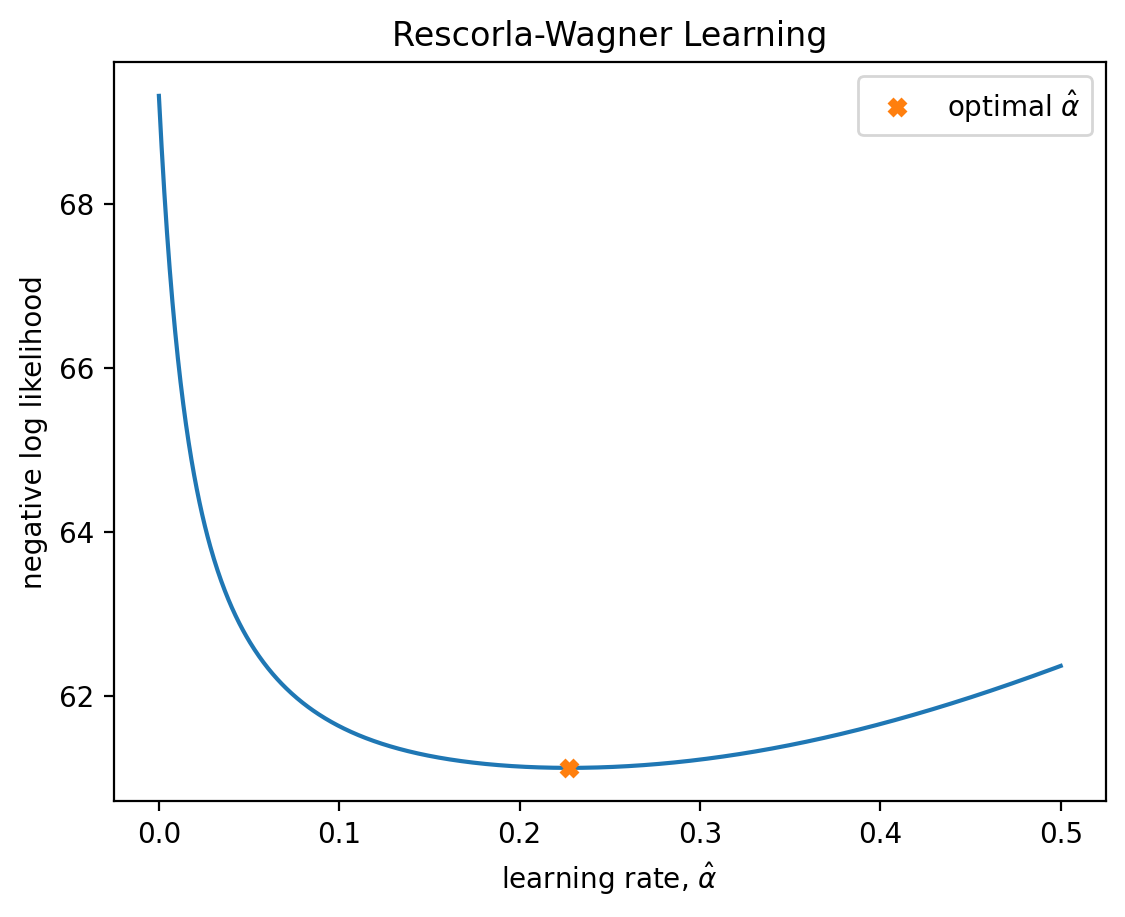

In [21]:
nLL = []
alpha_vals = np.linspace(0, 0.5, 1000)
for alpha_val in alpha_vals:
    nLL.append(negll_RescorlaWagner([alpha_val, theta], c4, r4))

plt.plot(alpha_vals, nLL, '-')
plt.plot(
    alpha_vals[np.argmin(nLL)], nLL[np.argmin(nLL)],
    'X', label=r'optimal $\hat \alpha$'
)
plt.ylabel('negative log likelihood')
plt.xlabel(fr'learning rate, $\hat \alpha$')
plt.title(f'Rescorla-Wagner Learning')
plt.legend()
plt.show()
